In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import cross_val_score, KFold
import os

In [2]:
DROPPED = [
    "dist_360_SPEED", "dist_360_THROTTLE", "dist_360_STEER", "dist_360_BRAKE",
    "dist_360_CURRENTLAPTIMEINMS", "dist_360_LAPDISTANCE", "dist_360_WORLDPOSITIONX", "dist_360_WORLDPOSITIONY",
    "dist_360_WORLDFORWARDDIRX", "dist_360_WORLDFORWARDDIRY", "dist_360_YAW", "dist_360_PITCH",
    "dist_360_ROLL", "dist_360_left_dist", "dist_360_right_dist", "dist_360_dist_apex_1",
    "dist_360_dist_apex_2", "dist_360_angle_to_apex1", "dist_360_angle_to_apex2", "dist_360_proj_from_ref",
    "dist_430_SPEED", "dist_430_THROTTLE", "dist_430_STEER", "dist_430_BRAKE",
    "dist_430_CURRENTLAPTIMEINMS", "dist_430_LAPDISTANCE", "dist_430_WORLDPOSITIONX", "dist_430_WORLDPOSITIONY",
    "dist_430_WORLDFORWARDDIRX", "dist_430_WORLDFORWARDDIRY", "dist_430_YAW", "dist_430_PITCH",
    "dist_430_ROLL", "dist_430_left_dist", "dist_430_right_dist", "dist_430_dist_apex_1",
    "dist_430_dist_apex_2", "dist_430_angle_to_apex1", "dist_430_angle_to_apex2", "dist_430_proj_from_ref",
    "dist_530_SPEED", "dist_530_THROTTLE", "dist_530_STEER", "dist_530_BRAKE",
    "dist_530_CURRENTLAPTIMEINMS", "dist_530_LAPDISTANCE", "dist_530_WORLDPOSITIONX", "dist_530_WORLDPOSITIONY",
    "dist_530_WORLDFORWARDDIRX", "dist_530_WORLDFORWARDDIRY", "dist_530_YAW", "dist_530_PITCH",
    "dist_530_ROLL", "dist_530_left_dist", "dist_530_right_dist", "dist_530_dist_apex_1",
    "dist_530_dist_apex_2", "dist_530_angle_to_apex1", "dist_530_angle_to_apex2", "dist_530_proj_from_ref",
    "BPS_right_dist", "BPE_right_dist", "THS_right_dist", "THE_right_dist", "STS_right_dist",
    "STM_right_dist", "STE_right_dist", "APX1_right_dist", "APX2_right_dist", "BPS_CURRENTLAPTIMEINMS",
    "BPE_CURRENTLAPTIMEINMS", "THS_CURRENTLAPTIMEINMS", "THE_CURRENTLAPTIMEINMS", "STS_CURRENTLAPTIMEINMS",
    "STM_CURRENTLAPTIMEINMS", "STE_CURRENTLAPTIMEINMS", "APX1_CURRENTLAPTIMEINMS", "APX2_CURRENTLAPTIMEINMS"
]

# Uploading Data and removing outliers and features

In [3]:
os.chdir(r"c:\Users\Haseeb Ijaz\OneDrive - UNSW\Desktop\DATA3001\Data3001-Modelling-2")
data = pd.read_csv("final_data_product.csv")
data = data.dropna().drop_duplicates().drop(columns=DROPPED).sort_values(by="Target_CURRENTLAPTIMEINMS")
target_mean = data["Target_CURRENTLAPTIMEINMS"].mean()
target_std = data["Target_CURRENTLAPTIMEINMS"].std()
data = data[data['Target_CURRENTLAPTIMEINMS'] < target_mean + 3 * target_std] # removes 12 longest times
y = data["Target_CURRENTLAPTIMEINMS"]
X = data.drop(columns=["Target_CURRENTLAPTIMEINMS", "lap_id", "invalid_lap"])

target_columns = [
    'target_CURRENTLAPTIMEINMS', '_LAPDISTANCE', '_WORLDPOSITIONX', 
    '_STEER', '_BRAKE', '_THROTTLE', '_WORLDPOSITIONY'
]

selected_columns = [col for col in X.columns if col.endswith(tuple(target_columns))]
X = X[selected_columns]

# target_points = [
#     'BPS', 'BPE'
# ]

# selected_columns = [col for col in X.columns if col.startswith(tuple(target_points))]
# X = X[selected_columns]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

scaler_X = StandardScaler()
scaler_X_split = StandardScaler()
scaler_y = StandardScaler()
scaler_y_split = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
X_train_scaled = scaler_X_split.fit_transform(X_train)
X_test_scaled = scaler_X_split.transform(X_test)

y_train_scaled = scaler_y_split.fit_transform(y_train.to_numpy().reshape(-1, 1)).ravel()
y_test_scaled = scaler_y_split.transform(y_test.to_numpy().reshape(-1, 1)).ravel()
y_scaled = scaler_y.fit_transform(y.to_numpy().reshape(-1, 1)).ravel()

# Feature selection

### Mutual information

In [5]:
from sklearn.feature_selection import mutual_info_regression

m_info = mutual_info_regression(X, y)
Scores = pd.DataFrame(sorted(zip(X.columns, m_info), key=lambda x: x[1], reverse=True), columns=["feature", "mi_score"])
pd.set_option('display.max_rows', 200)
Scores

,feature,mi_score
0,STE_THROTTLE,0.236379
1,STS_ext_LAPDISTANCE,0.185634
2,STM_WORLDPOSITIONY,0.185202
3,THE_ext_LAPDISTANCE,0.183891
4,STE_LAPDISTANCE,0.182095
5,STM_THROTTLE,0.178770
6,APX2_THROTTLE,0.177809
7,STM_LAPDISTANCE,0.164082
8,THE_LAPDISTANCE,0.163695
9,STS_WORLDPOSITIONY,0.158699


# Detecting mutlicollinearity

### Variance inflation factor

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
X = add_constant(X)
vif_data['feature'] = X.columns
vif_data["VIF"] = [round(variance_inflation_factor(X.values, i), 4) for i in range(X.shape[1])]
vif_data[vif_data["VIF"] < 10].sort_values(by="VIF")#.iloc[:,0]
# vif_data

,feature,VIF
56,APX2_STEER,1.2280
16,THS_STEER,1.3180
43,STE_STEER,1.3964
3,BPS_BRAKE,1.4252
37,STM_STEER,1.4709
22,THE_THROTTLE,1.4841
17,THS_BRAKE,1.4929
2,BPS_STEER,1.5476
57,APX2_BRAKE,1.5691
30,STS_STEER,1.6337


# Modelling

### SVR (scaled data without feature selection and without addressing mutlicollinearity)

In [7]:
poly_parameters = {
    'kernel': ['poly'],
    'degree': [2, 3, 4, 5],
    'gamma': ['scale', 'auto'],
    'coef0': [1, 2, 3, 4, 5],
    'tol': [1e-06],
    'C': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'epsilon': [0.001],
    'shrinking': [True],
    'verbose': [True],
    'max_iter': [-1]
}

from sklearn.svm import SVR

grid_poly = GridSearchCV(
    estimator=SVR(),
    param_grid=poly_parameters,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

grid_poly.fit(X_train_scaled, y_train_scaled)
print("Best parameters:", grid_poly.best_params_)
print("Best RMSE:", abs(grid_poly.best_score_))
y_pred_poly_scaled = grid_poly.predict(X_test_scaled)
y_pred_poly = scaler_y_split.inverse_transform(y_pred_poly_scaled.reshape(-1,1))

rmse_poly = root_mean_squared_error(y_pred_poly, y_test)
r2_poly = r2_score(y_pred_poly, y_test)
print("RMSE for poly kernel:", rmse_poly)
print("R² for poly kernel:", r2_poly)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[LibSVM]Best parameters: {'C': 0.1, 'coef0': 2, 'degree': 2, 'epsilon': 0.001, 'gamma': 'auto', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 1e-06, 'verbose': True}
Best RMSE: 0.7264873799508692
RMSE for poly kernel: 2315.344733588483
R² for poly kernel: -0.3480218405449529


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LibSVM]Best parameters: {'C': 0.3, 'coef0': 3, 'degree': 3, 'epsilon': 0.0005, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 1e-06, 'verbose': True}
Best RMSE: 0.549755590951283
RMSE for poly kernel: 1551.693230307914
R² for poly kernel: 0.6867939663481857

<!-- Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LibSVM]Best parameters: {'C': 0.3, 'coef0': 3, 'degree': 3, 'epsilon': 0.0005, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 1e-06, 'verbose': True}
Best RMSE: 0.549755590951283
RMSE for poly kernel: 1551.693230307914
R² for poly kernel: 0.6867939663481857 -->

### CV

In [8]:
fold_rmse = []
fold_R2 = []

for i in range(4):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=i+4)
    model = SVR(kernel='poly', degree=3, gamma='scale',
                    coef0=3, tol=1e-3,C=0.1, epsilon=0.0005,
                    shrinking=True, verbose=2,max_iter=-1)
    
    scaler_X_split = StandardScaler()
    scaler_y_split = StandardScaler()
    X_train_scaled = scaler_X_split.fit_transform(X_train)
    X_test_scaled = scaler_X_split.transform(X_test)
    y_train_scaled = scaler_y_split.fit_transform(y_train.to_numpy().reshape(-1, 1)).ravel()
    y_test_scaled = scaler_y_split.transform(y_test.to_numpy().reshape(-1, 1)).ravel()

    model.fit(X_train_scaled, y_train_scaled)

    y_pred_poly_scaled = model.predict(X_test_scaled)
    y_pred_poly = scaler_y_split.inverse_transform(y_pred_poly_scaled.reshape(-1,1))

    fold_rmse.append(root_mean_squared_error(y_pred_poly, y_test))
    fold_R2.append(r2_score(y_pred_poly, y_test))

print("\n4-fold CV RMSE:")
print("Fold RMSEs:", np.round(fold_rmse, 3))
print("Mean RMSE :", np.round(np.mean(fold_rmse), 3))
print("Std  RMSE :", np.round(np.std(fold_rmse), 3))
print("\n4-fold CV R2:")
print("Fold RMSEs:", np.round(fold_R2, 3))
print("Mean RMSE :", np.round(np.mean(fold_R2), 3))
print("Std  RMSE :", np.round(np.std(fold_R2), 3))

[LibSVM][LibSVM][LibSVM][LibSVM]
4-fold CV RMSE:
Fold RMSEs: [2800.283 3708.039 2550.26  3515.342]
Mean RMSE : 3143.481
Std  RMSE : 481.327

4-fold CV R2:
Fold RMSEs: [-0.273 -0.213 -0.124  0.416]
Mean RMSE : -0.048
Std  RMSE : 0.273


# Finding optimum using model

In [9]:
print(os.getcwd())

c:\Users\Haseeb Ijaz\OneDrive - UNSW\Desktop\DATA3001\Data3001-Modelling-2


In [10]:
from shapely.geometry import Point,Polygon

os.chdir(r"c:\Users\Haseeb Ijaz\OneDrive - UNSW\Desktop\DATA3001")
track_left = pd.read_csv("Data3001G2/data/f1sim-ref-left.csv")
track_right = pd.read_csv("Data3001G2/data/f1sim-ref-right.csv")
track_line = pd.read_csv("Data3001G2/data/f1sim-ref-line.csv")
turns = pd.read_csv("Data3001G2/data/f1sim-ref-turns.csv")

track_poly = Polygon(
    np.vstack([
        track_left[['WORLDPOSX', 'WORLDPOSY']].values,
        track_right[['WORLDPOSX', 'WORLDPOSY']].values[::-1]
    ])
)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns[1:])
y_scaled_df = pd.DataFrame(y_scaled, columns=["Target_CURRENTLAPTIMEINMS"])

x_cols = sorted([c for c in X_scaled_df.columns if "WORLDPOSITIONX" in c])
y_cols = sorted([c for c in X_scaled_df.columns if "WORLDPOSITIONY" in c])

def sampling(bounds, N, rng, x_cols, y_cols):
    xy_pairs = list(zip(x_cols, y_cols))
    valid = []

    while len(valid) < N:
        cand_idx = rng.integers(0, len(X_scaled_df))
        cand = X_scaled_df.iloc[cand_idx].to_dict()

        all_inside = True
        for xc, yc in xy_pairs:
            x = cand[xc]
            y = cand[yc]

            if not track_poly.contains(Point(x, y)):
                all_inside = False
                break
        if all_inside:
            valid.append(cand)
    return pd.DataFrame(valid)

In [11]:
percentiles = (0.05, 0.95)

bounds = {
    f: (X_scaled_df[f].quantile(percentiles[0]),
        X_scaled_df[f].quantile(percentiles[1]))
    for f in X_scaled_df.columns
}

rng = np.random.default_rng(42)
N = 5000

Xcand = sampling(bounds, N, rng, x_cols, y_cols)
Xcand = Xcand[X_scaled_df.columns]

ycand = grid_poly.predict(Xcand)
ycand_unscaled = scaler_y.inverse_transform(ycand.reshape(-1, 1)).ravel()

imin = int(np.argmin(ycand_unscaled))
best_combo_scaled = Xcand.iloc[imin].to_frame().T
best_combo_unscaled = pd.DataFrame(
    scaler_X.inverse_transform(best_combo_scaled),
    columns=X.columns[1:]
)

best_pred = ycand_unscaled[imin]

print("\n=== SVR-suggested first-brake setup (within observed range) ===")
for k, v in best_combo_unscaled.iloc[0].items():
    print(f"{k}: {v:,.4f}")
print(f"Predicted Target_CURRENTLAPTIMEINMS: {best_pred:,.3f}")



=== SVR-suggested first-brake setup (within observed range) ===
BPS_THROTTLE: 1.0000
BPS_STEER: -0.0056
BPS_BRAKE: 0.0000
BPS_LAPDISTANCE: 262.0000
BPS_WORLDPOSITIONX: 301.3049
BPS_WORLDPOSITIONY: 285.5776
BPS_ext_LAPDISTANCE: 302.0000
BPE_THROTTLE: 0.0000
BPE_STEER: 0.1439
BPE_BRAKE: 0.9612
BPE_LAPDISTANCE: 332.0000
BPE_WORLDPOSITIONX: 351.4517
BPE_WORLDPOSITIONY: 236.7072
BPE_ext_LAPDISTANCE: 347.0000
THS_THROTTLE: 0.9697
THS_STEER: 0.0012
THS_BRAKE: 0.2811
THS_LAPDISTANCE: 277.0000
THS_WORLDPOSITIONX: 312.1923
THS_WORLDPOSITIONY: 275.2520
THS_ext_LAPDISTANCE: 302.0000
THE_THROTTLE: 0.0792
THE_STEER: 0.4563
THE_BRAKE: 0.0000
THE_LAPDISTANCE: 348.0000
THE_WORLDPOSITIONX: 361.5939
THE_WORLDPOSITIONY: 224.1674
THE_ext_LAPDISTANCE: 405.0000
STS_THROTTLE: 0.0000
STS_STEER: 0.0094
STS_BRAKE: 1.0000
STS_LAPDISTANCE: 307.0000
STS_WORLDPOSITIONX: 333.8156
STS_WORLDPOSITIONY: 254.4434
STS_ext_LAPDISTANCE: 382.0000
STM_THROTTLE: 1.0000
STM_STEER: 0.0000
STM_BRAKE: 0.0000
STM_LAPDISTANCE: 427.1

c:\Users\Haseeb Ijaz\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


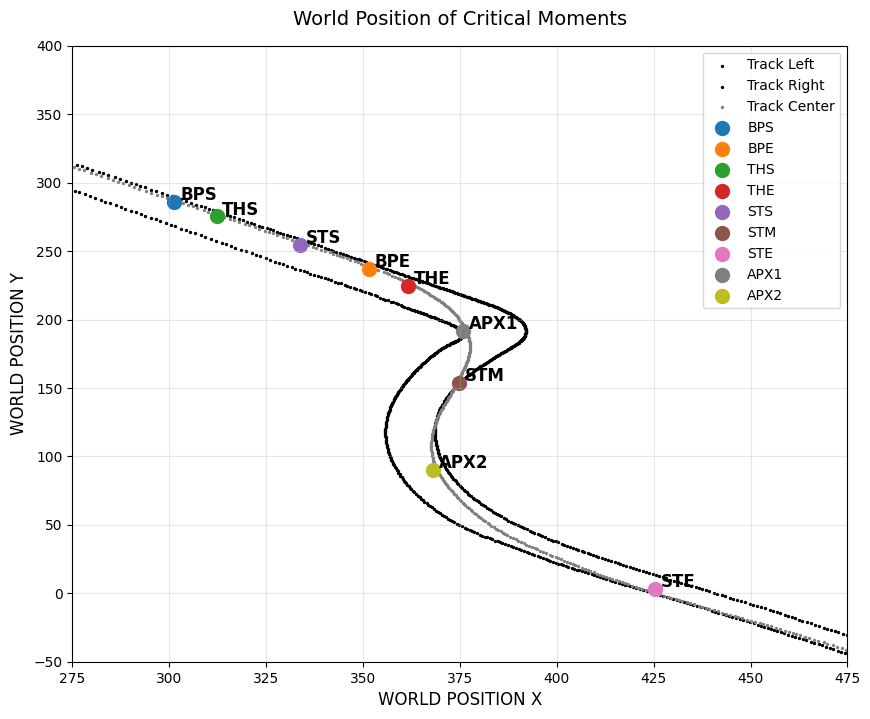

In [12]:
import matplotlib.pyplot as plt

points = {}

prefixes = ["BPS", "BPE", "THS", "THE", "STS", "STM", "STE", "APX1", "APX2"]

row = best_combo_unscaled.iloc[0]
for p in prefixes:
    x_col = f"{p}_WORLDPOSITIONX"
    y_col = f"{p}_WORLDPOSITIONY"
    
    if x_col in row and y_col in row:
        points[p] = (float(row[x_col]), float(row[y_col]))

plt.figure(figsize=(10, 8))
f = 100000
# Track boundaries/centerline
plt.scatter(track_left.loc[track_left["FRAME"] <= f,  "WORLDPOSX"],
            track_left.loc[track_left["FRAME"] <= f,  "WORLDPOSY"],
            s=2, color="black", label="Track Left")
plt.scatter(track_right.loc[track_right["FRAME"] <= f, "WORLDPOSX"],
            track_right.loc[track_right["FRAME"] <= f, "WORLDPOSY"],
            s=2, color="black", label="Track Right")
plt.scatter(track_line.loc[track_line["FRAME"] <= f,  "WORLDPOSX"],
            track_line.loc[track_line["FRAME"] <= f,  "WORLDPOSY"],
            s=2, color="gray",  label="Track Center")

# Plot setup
for name, (x, y) in points.items():
    plt.scatter(x, y, s=100, label=name)
    plt.text(x + 1.5, y + 1.5, name, fontsize=12, weight="bold")

# Styling
plt.xlabel("WORLD POSITION X", fontsize=12)
plt.ylabel("WORLD POSITION Y", fontsize=12)
plt.title("World Position of Critical Moments", fontsize=14, pad=15)
plt.grid(alpha=0.3)
plt.legend()
plt.xlim(275, 475)
plt.ylim(-50, 400)
plt.show()


# Partial Poly Graph

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Example: 3 feature dataset (X1, X2, X3)
# X is your input matrix with shape (n_samples, n_features)
# y is your target variable
X = np.random.rand(100, 3) * 10  # Random data with 3 features
y = np.sin(X[:, 0]) + 0.5 * X[:, 1] + np.random.randn(100)  # Target variable with noise

# Scaling the data
sc_X = StandardScaler()
sc_y = StandardScaler()

X_scaled = sc_X.fit_transform(X)
y_scaled = sc_y.fit_transform(y.reshape(-1, 1)).ravel()

# Train the SVR model with a polynomial kernel
svr_poly = SVR(kernel='poly', degree=3, C=100, epsilon=0.1)
svr_poly.fit(X_scaled, y_scaled)

# 1. Compute the 95th percentiles for each feature (for input ranges)
percentiles = np.percentile(X, 95, axis=0)

# 2. Plot Partial Poly Graphs for each feature
for feature_index in range(X.shape[1]):
    # Vary the current feature (e.g., X1) across the top 95 percentile range
    feature_range = np.linspace(0, percentiles[feature_index], 1000).reshape(-1, 1)

    # Fix the other features at their mean values
    X_fixed = np.mean(X[:, np.arange(X.shape[1]) != feature_index], axis=0)

    # Create the combined input data with the varied feature and fixed others
    X_combined = np.hstack([feature_range, np.tile(X_fixed, (feature_range.shape[0], 1))])

    # Scale the new data for prediction
    X_combined_scaled = sc_X.transform(X_combined)

    # Predict using the trained SVR model
    y_pred_scaled = svr_poly.predict(X_combined_scaled)

    # Inverse transform the predictions to get original scale
    y_pred = sc_y.inverse_transform(y_pred_scaled)

    # Plot the result
    plt.figure(figsize=(8, 6))
    plt.plot(feature_range, y_pred, label=f"SVR Polynomial Fit (Varying Feature {feature_index+1})")
    plt.title(f'Partial Poly Graph (Varying Feature {feature_index+1})')
    plt.xlabel(f'Feature {feature_index+1}')
    plt.ylabel('Predicted y')
    plt.legend()
    plt.show()

# 3. Plot Partial Dependence for Pairs of Features (2D Contour Plots)
for i in range(X.shape[1]):
    for j in range(i + 1, X.shape[1]):
        # Create a grid of values for Feature i and Feature j
        feature1_range = np.linspace(0, percentiles[i], 100)
        feature2_range = np.linspace(0, percentiles[j], 100)
        
        # Create a meshgrid for the 2D grid of Feature i and Feature j
        feature1_grid, feature2_grid = np.meshgrid(feature1_range, feature2_range)
        
        # Create a combined grid of features for prediction
        X_grid = np.vstack([feature1_grid.ravel(), feature2_grid.ravel()]).T
        
        # Fix the other features at their mean value
        X_fixed = np.mean(X[:, [k for k in range(X.shape[1]) if k != i and k != j]], axis=0)
        
        # Combine the grid values with the fixed feature values
        X_combined = np.hstack([X_grid, np.full((X_grid.shape[0], len(X_fixed)), X_fixed)])

        # Scale the new data for prediction
        X_combined_scaled = sc_X.transform(X_combined)

        # Predict using the trained SVR model
        y_pred_scaled = svr_poly.predict(X_combined_scaled)

        # Inverse transform the predictions to get original scale
        y_pred = sc_y.inverse_transform(y_pred_scaled)

        # Reshape the predictions back into the grid shape
        y_pred_grid = y_pred.reshape(feature1_grid.shape)

        # Plot the results as a contour plot (for 2D data)
        plt.figure(figsize=(8, 6))
        plt.contourf(feature1_range, feature2_range, y_pred_grid, levels=50, cmap='coolwarm')
        plt.colorbar(label='Predicted y')
        plt.title(f'Partial Dependence (Varying Features {i+1} and {j+1})')
        plt.xlabel(f'Feature {i+1}')
        plt.ylabel(f'Feature {j+1}')
        plt.show()


ValueError: Expected 2D array, got 1D array instead:
array=[ 9.68491579e-01  9.63666698e-01  9.58859071e-01  9.54068668e-01
  9.49295458e-01  9.44539409e-01  9.39800492e-01  9.35078674e-01
  9.30373926e-01  9.25686215e-01  9.21015512e-01  9.16361785e-01
  9.11725004e-01  9.07105137e-01  9.02502154e-01  8.97916024e-01
  8.93346715e-01  8.88794198e-01  8.84258440e-01  8.79739412e-01
  8.75237081e-01  8.70751418e-01  8.66282392e-01  8.61829970e-01
  8.57394124e-01  8.52974821e-01  8.48572030e-01  8.44185722e-01
  8.39815865e-01  8.35462427e-01  8.31125379e-01  8.26804689e-01
  8.22500326e-01  8.18212259e-01  8.13940458e-01  8.09684892e-01
  8.05445529e-01  8.01222339e-01  7.97015291e-01  7.92824354e-01
  7.88649497e-01  7.84490689e-01  7.80347899e-01  7.76221097e-01
  7.72110251e-01  7.68015330e-01  7.63936304e-01  7.59873142e-01
  7.55825813e-01  7.51794285e-01  7.47778528e-01  7.43778512e-01
  7.39794204e-01  7.35825575e-01  7.31872593e-01  7.27935228e-01
  7.24013448e-01  7.20107222e-01  7.16216520e-01  7.12341312e-01
  7.08481565e-01  7.04637249e-01  7.00808333e-01  6.96994786e-01
  6.93196577e-01  6.89413676e-01  6.85646051e-01  6.81893672e-01
  6.78156507e-01  6.74434526e-01  6.70727698e-01  6.67035992e-01
  6.63359377e-01  6.59697822e-01  6.56051296e-01  6.52419768e-01
  6.48803208e-01  6.45201584e-01  6.41614866e-01  6.38043022e-01
  6.34486022e-01  6.30943835e-01  6.27416429e-01  6.23903775e-01
  6.20405841e-01  6.16922596e-01  6.13454009e-01  6.10000050e-01
  6.06560687e-01  6.03135890e-01  5.99725627e-01  5.96329868e-01
  5.92948582e-01  5.89581738e-01  5.86229305e-01  5.82891252e-01
  5.79567548e-01  5.76258162e-01  5.72963064e-01  5.69682223e-01
  5.66415607e-01  5.63163185e-01  5.59924928e-01  5.56700803e-01
  5.53490780e-01  5.50294828e-01  5.47112916e-01  5.43945014e-01
  5.40791090e-01  5.37651113e-01  5.34525053e-01  5.31412878e-01
  5.28314558e-01  5.25230062e-01  5.22159358e-01  5.19102417e-01
  5.16059206e-01  5.13029696e-01  5.10013855e-01  5.07011652e-01
  5.04023057e-01  5.01048038e-01  4.98086565e-01  4.95138607e-01
  4.92204132e-01  4.89283110e-01  4.86375510e-01  4.83481301e-01
  4.80600453e-01  4.77732933e-01  4.74878712e-01  4.72037759e-01
  4.69210042e-01  4.66395530e-01  4.63594194e-01  4.60806001e-01
  4.58030921e-01  4.55268922e-01  4.52519975e-01  4.49784049e-01
  4.47061111e-01  4.44351132e-01  4.41654080e-01  4.38969925e-01
  4.36298635e-01  4.33640180e-01  4.30994529e-01  4.28361651e-01
  4.25741515e-01  4.23134090e-01  4.20539345e-01  4.17957249e-01
  4.15387772e-01  4.12830882e-01  4.10286549e-01  4.07754742e-01
  4.05235429e-01  4.02728580e-01  4.00234164e-01  3.97752150e-01
  3.95282507e-01  3.92825204e-01  3.90380210e-01  3.87947495e-01
  3.85527028e-01  3.83118777e-01  3.80722711e-01  3.78338801e-01
  3.75967014e-01  3.73607320e-01  3.71259688e-01  3.68924087e-01
  3.66600487e-01  3.64288856e-01  3.61989163e-01  3.59701378e-01
  3.57425469e-01  3.55161406e-01  3.52909157e-01  3.50668693e-01
  3.48439982e-01  3.46222992e-01  3.44017694e-01  3.41824056e-01
  3.39642047e-01  3.37471637e-01  3.35312794e-01  3.33165488e-01
  3.31029687e-01  3.28905361e-01  3.26792480e-01  3.24691011e-01
  3.22600924e-01  3.20522188e-01  3.18454773e-01  3.16398647e-01
  3.14353779e-01  3.12320139e-01  3.10297695e-01  3.08286417e-01
  3.06286274e-01  3.04297235e-01  3.02319269e-01  3.00352345e-01
  2.98396432e-01  2.96451499e-01  2.94517516e-01  2.92594451e-01
  2.90682273e-01  2.88780953e-01  2.86890458e-01  2.85010757e-01
  2.83141821e-01  2.81283618e-01  2.79436117e-01  2.77599286e-01
  2.75773097e-01  2.73957516e-01  2.72152514e-01  2.70358060e-01
  2.68574122e-01  2.66800670e-01  2.65037673e-01  2.63285100e-01
  2.61542919e-01  2.59811101e-01  2.58089614e-01  2.56378427e-01
  2.54677510e-01  2.52986831e-01  2.51306360e-01  2.49636065e-01
  2.47975917e-01  2.46325883e-01  2.44685932e-01  2.43056035e-01
  2.41436160e-01  2.39826277e-01  2.38226353e-01  2.36636359e-01
  2.35056264e-01  2.33486036e-01  2.31925644e-01  2.30375059e-01
  2.28834248e-01  2.27303181e-01  2.25781828e-01  2.24270156e-01
  2.22768136e-01  2.21275736e-01  2.19792925e-01  2.18319673e-01
  2.16855948e-01  2.15401720e-01  2.13956958e-01  2.12521631e-01
  2.11095708e-01  2.09679158e-01  2.08271950e-01  2.06874053e-01
  2.05485436e-01  2.04106069e-01  2.02735921e-01  2.01374960e-01
  2.00023156e-01  1.98680477e-01  1.97346894e-01  1.96022374e-01
  1.94706888e-01  1.93400403e-01  1.92102890e-01  1.90814317e-01
  1.89534654e-01  1.88263869e-01  1.87001932e-01  1.85748812e-01
  1.84504477e-01  1.83268897e-01  1.82042042e-01  1.80823879e-01
  1.79614379e-01  1.78413509e-01  1.77221241e-01  1.76037541e-01
  1.74862380e-01  1.73695727e-01  1.72537551e-01  1.71387820e-01
  1.70246504e-01  1.69113572e-01  1.67988994e-01  1.66872737e-01
  1.65764772e-01  1.64665067e-01  1.63573592e-01  1.62490315e-01
  1.61415206e-01  1.60348234e-01  1.59289367e-01  1.58238576e-01
  1.57195828e-01  1.56161094e-01  1.55134341e-01  1.54115540e-01
  1.53104660e-01  1.52101669e-01  1.51106536e-01  1.50119231e-01
  1.49139723e-01  1.48167981e-01  1.47203974e-01  1.46247671e-01
  1.45299040e-01  1.44358052e-01  1.43424676e-01  1.42498880e-01
  1.41580633e-01  1.40669905e-01  1.39766664e-01  1.38870881e-01
  1.37982523e-01  1.37101560e-01  1.36227961e-01  1.35361696e-01
  1.34502732e-01  1.33651040e-01  1.32806589e-01  1.31969346e-01
  1.31139283e-01  1.30316367e-01  1.29500568e-01  1.28691855e-01
  1.27890197e-01  1.27095563e-01  1.26307922e-01  1.25527243e-01
  1.24753495e-01  1.23986648e-01  1.23226671e-01  1.22473532e-01
  1.21727201e-01  1.20987647e-01  1.20254838e-01  1.19528745e-01
  1.18809336e-01  1.18096580e-01  1.17390446e-01  1.16690903e-01
  1.15997921e-01  1.15311468e-01  1.14631515e-01  1.13958028e-01
  1.13290979e-01  1.12630336e-01  1.11976067e-01  1.11328143e-01
  1.10686532e-01  1.10051203e-01  1.09422125e-01  1.08799268e-01
  1.08182601e-01  1.07572092e-01  1.06967711e-01  1.06369426e-01
  1.05777208e-01  1.05191025e-01  1.04610845e-01  1.04036639e-01
  1.03468376e-01  1.02906023e-01  1.02349551e-01  1.01798929e-01
  1.01254125e-01  1.00715110e-01  1.00181850e-01  9.96543174e-02
  9.91324793e-02  9.86163054e-02  9.81057646e-02  9.76008262e-02
  9.71014592e-02  9.66076327e-02  9.61193157e-02  9.56364775e-02
  9.51590870e-02  9.46871134e-02  9.42205257e-02  9.37592930e-02
  9.33033846e-02  9.28527693e-02  9.24074164e-02  9.19672948e-02
  9.15323738e-02  9.11026224e-02  9.06780097e-02  9.02585048e-02
  8.98440767e-02  8.94346946e-02  8.90303276e-02  8.86309447e-02
  8.82365151e-02  8.78470078e-02  8.74623919e-02  8.70826366e-02
  8.67077108e-02  8.63375838e-02  8.59722246e-02  8.56116023e-02
  8.52556859e-02  8.49044447e-02  8.45578476e-02  8.42158637e-02
  8.38784622e-02  8.35456122e-02  8.32172827e-02  8.28934428e-02
  8.25740616e-02  8.22591083e-02  8.19485519e-02  8.16423614e-02
  8.13405061e-02  8.10429549e-02  8.07496770e-02  8.04606415e-02
  8.01758175e-02  7.98951739e-02  7.96186801e-02  7.93463050e-02
  7.90780177e-02  7.88137873e-02  7.85535829e-02  7.82973737e-02
  7.80451286e-02  7.77968168e-02  7.75524074e-02  7.73118695e-02
  7.70751722e-02  7.68422845e-02  7.66131755e-02  7.63878144e-02
  7.61661703e-02  7.59482121e-02  7.57339091e-02  7.55232303e-02
  7.53161448e-02  7.51126217e-02  7.49126301e-02  7.47161391e-02
  7.45231177e-02  7.43335351e-02  7.41473604e-02  7.39645626e-02
  7.37851109e-02  7.36089743e-02  7.34361219e-02  7.32665228e-02
  7.31001462e-02  7.29369611e-02  7.27769365e-02  7.26200416e-02
  7.24662456e-02  7.23155174e-02  7.21678261e-02  7.20231409e-02
  7.18814309e-02  7.17426651e-02  7.16068127e-02  7.14738426e-02
  7.13437241e-02  7.12164262e-02  7.10919180e-02  7.09701686e-02
  7.08511471e-02  7.07348225e-02  7.06211641e-02  7.05101408e-02
  7.04017217e-02  7.02958760e-02  7.01925728e-02  7.00917811e-02
  6.99934700e-02  6.98976086e-02  6.98041660e-02  6.97131113e-02
  6.96244137e-02  6.95380421e-02  6.94539657e-02  6.93721535e-02
  6.92925748e-02  6.92151984e-02  6.91399937e-02  6.90669295e-02
  6.89959752e-02  6.89270996e-02  6.88602719e-02  6.87954613e-02
  6.87326367e-02  6.86717674e-02  6.86128223e-02  6.85557706e-02
  6.85005814e-02  6.84472238e-02  6.83956668e-02  6.83458795e-02
  6.82978311e-02  6.82514906e-02  6.82068272e-02  6.81638098e-02
  6.81224077e-02  6.80825898e-02  6.80443254e-02  6.80075834e-02
  6.79723331e-02  6.79385434e-02  6.79061834e-02  6.78752223e-02
  6.78456292e-02  6.78173731e-02  6.77904231e-02  6.77647483e-02
  6.77403179e-02  6.77171009e-02  6.76950663e-02  6.76741834e-02
  6.76544211e-02  6.76357487e-02  6.76181351e-02  6.76015494e-02
  6.75859608e-02  6.75713384e-02  6.75576512e-02  6.75448683e-02
  6.75329588e-02  6.75218919e-02  6.75116365e-02  6.75021619e-02
  6.74934370e-02  6.74854311e-02  6.74781131e-02  6.74714522e-02
  6.74654174e-02  6.74599779e-02  6.74551027e-02  6.74507610e-02
  6.74469218e-02  6.74435542e-02  6.74406274e-02  6.74381103e-02
  6.74359721e-02  6.74341820e-02  6.74327089e-02  6.74315220e-02
  6.74305903e-02  6.74298831e-02  6.74293692e-02  6.74290179e-02
  6.74287983e-02  6.74286794e-02  6.74286303e-02  6.74286201e-02
  6.74286179e-02  6.74285928e-02  6.74285139e-02  6.74283503e-02
  6.74280710e-02  6.74276453e-02  6.74270420e-02  6.74262305e-02
  6.74251796e-02  6.74238587e-02  6.74222366e-02  6.74202826e-02
  6.74179656e-02  6.74152549e-02  6.74121195e-02  6.74085284e-02
  6.74044509e-02  6.73998559e-02  6.73947126e-02  6.73889900e-02
  6.73826573e-02  6.73756835e-02  6.73680378e-02  6.73596892e-02
  6.73506068e-02  6.73407597e-02  6.73301171e-02  6.73186479e-02
  6.73063213e-02  6.72931064e-02  6.72789722e-02  6.72638880e-02
  6.72478227e-02  6.72307454e-02  6.72126253e-02  6.71934314e-02
  6.71731328e-02  6.71516987e-02  6.71290980e-02  6.71053000e-02
  6.70802737e-02  6.70539881e-02  6.70264124e-02  6.69975157e-02
  6.69672671e-02  6.69356356e-02  6.69025904e-02  6.68681005e-02
  6.68321350e-02  6.67946631e-02  6.67556538e-02  6.67150762e-02
  6.66728994e-02  6.66290925e-02  6.65836246e-02  6.65364647e-02
  6.64875820e-02  6.64369456e-02  6.63845246e-02  6.63302880e-02
  6.62742049e-02  6.62162445e-02  6.61563758e-02  6.60945679e-02
  6.60307899e-02  6.59650109e-02  6.58972000e-02  6.58273263e-02
  6.57553589e-02  6.56812668e-02  6.56050192e-02  6.55265852e-02
  6.54459338e-02  6.53630342e-02  6.52778553e-02  6.51903664e-02
  6.51005365e-02  6.50083348e-02  6.49137302e-02  6.48166919e-02
  6.47171890e-02  6.46151906e-02  6.45106658e-02  6.44035836e-02
  6.42939131e-02  6.41816235e-02  6.40666839e-02  6.39490633e-02
  6.38287308e-02  6.37056555e-02  6.35798065e-02  6.34511529e-02
  6.33196639e-02  6.31853084e-02  6.30480555e-02  6.29078745e-02
  6.27647343e-02  6.26186041e-02  6.24694529e-02  6.23172498e-02
  6.21619640e-02  6.20035645e-02  6.18420204e-02  6.16773008e-02
  6.15093748e-02  6.13382115e-02  6.11637800e-02  6.09860494e-02
  6.08049887e-02  6.06205671e-02  6.04327536e-02  6.02415174e-02
  6.00468275e-02  5.98486531e-02  5.96469632e-02  5.94417269e-02
  5.92329133e-02  5.90204915e-02  5.88044305e-02  5.85846996e-02
  5.83612677e-02  5.81341040e-02  5.79031776e-02  5.76684575e-02
  5.74299129e-02  5.71875128e-02  5.69412263e-02  5.66910226e-02
  5.64368706e-02  5.61787396e-02  5.59165985e-02  5.56504166e-02
  5.53801628e-02  5.51058063e-02  5.48273162e-02  5.45446615e-02
  5.42578114e-02  5.39667349e-02  5.36714012e-02  5.33717793e-02
  5.30678383e-02  5.27595473e-02  5.24468754e-02  5.21297917e-02
  5.18082654e-02  5.14822653e-02  5.11517608e-02  5.08167208e-02
  5.04771145e-02  5.01329109e-02  4.97840792e-02  4.94305884e-02
  4.90724077e-02  4.87095060e-02  4.83418526e-02  4.79694165e-02
  4.75921667e-02  4.72100725e-02  4.68231028e-02  4.64312268e-02
  4.60344136e-02  4.56326322e-02  4.52258518e-02  4.48140414e-02
  4.43971702e-02  4.39752071e-02  4.35481214e-02  4.31158821e-02
  4.26784583e-02  4.22358191e-02  4.17879336e-02  4.13347709e-02
  4.08763000e-02  4.04124901e-02  3.99433103e-02  3.94687296e-02
  3.89887172e-02  3.85032420e-02  3.80122734e-02  3.75157802e-02
  3.70137316e-02  3.65060967e-02  3.59928447e-02  3.54739445e-02
  3.49493653e-02  3.44190762e-02  3.38830462e-02  3.33412445e-02
  3.27936401e-02  3.22402022e-02  3.16808998e-02  3.11157020e-02
  3.05445779e-02  2.99674967e-02  2.93844273e-02  2.87953390e-02
  2.82002007e-02  2.75989816e-02  2.69916508e-02  2.63781773e-02
  2.57585303e-02  2.51326789e-02  2.45005921e-02  2.38622390e-02
  2.32175887e-02  2.25666104e-02  2.19092730e-02  2.12455458e-02
  2.05753977e-02  1.98987980e-02  1.92157156e-02  1.85261197e-02
  1.78299793e-02  1.71272636e-02  1.64179416e-02  1.57019825e-02
  1.49793553e-02  1.42500292e-02  1.35139731e-02  1.27711563e-02
  1.20215477e-02  1.12651166e-02  1.05018319e-02  9.73166282e-03
  8.95457839e-03  8.17054773e-03  7.37953992e-03  6.58152405e-03
  5.77646922e-03  4.96434452e-03  4.14511904e-03  3.31876188e-03
  2.48524212e-03  1.64452887e-03  7.96591199e-04 -5.86017859e-05
 -9.21080995e-04 -1.79087734e-03 -2.66802172e-03 -3.55254505e-03
 -4.44447823e-03 -5.34385218e-03 -6.25069780e-03 -7.16504600e-03
 -8.08692769e-03 -9.01637377e-03 -9.95341515e-03 -1.08980827e-02
 -1.18504075e-02 -1.28104202e-02 -1.37781519e-02 -1.47536334e-02
 -1.57368956e-02 -1.67279695e-02 -1.77268860e-02 -1.87336760e-02
 -1.97483703e-02 -2.07709999e-02 -2.18015957e-02 -2.28401887e-02
 -2.38868096e-02 -2.49414894e-02 -2.60042591e-02 -2.70751495e-02
 -2.81541916e-02 -2.92414162e-02 -3.03368542e-02 -3.14405366e-02
 -3.25524943e-02 -3.36727582e-02 -3.48013592e-02 -3.59383281e-02
 -3.70836960e-02 -3.82374937e-02 -3.93997521e-02 -4.05705021e-02
 -4.17497746e-02 -4.29376006e-02 -4.41340110e-02 -4.53390366e-02
 -4.65527084e-02 -4.77750572e-02 -4.90061140e-02 -5.02459097e-02
 -5.14944753e-02 -5.27518415e-02 -5.40180393e-02 -5.52930997e-02
 -5.65770534e-02 -5.78699315e-02 -5.91717649e-02 -6.04825844e-02
 -6.18024210e-02 -6.31313055e-02 -6.44692689e-02 -6.58163421e-02
 -6.71725560e-02 -6.85379415e-02 -6.99125294e-02 -7.12963508e-02
 -7.26894366e-02 -7.40918175e-02 -7.55035246e-02 -7.69245887e-02
 -7.83550408e-02 -7.97949117e-02 -8.12442324e-02 -8.27030338e-02
 -8.41713468e-02 -8.56492022e-02 -8.71366311e-02 -8.86336643e-02
 -9.01403326e-02 -9.16566671e-02 -9.31826986e-02 -9.47184581e-02
 -9.62639764e-02 -9.78192845e-02 -9.93844132e-02 -1.00959393e-01
 -1.02544256e-01 -1.04139032e-01 -1.05743753e-01 -1.07358448e-01
 -1.08983150e-01 -1.10617889e-01 -1.12262696e-01 -1.13917601e-01
 -1.15582636e-01 -1.17257832e-01 -1.18943220e-01 -1.20638830e-01
 -1.22344693e-01 -1.24060841e-01 -1.25787303e-01 -1.27524112e-01
 -1.29271298e-01 -1.31028892e-01 -1.32796924e-01 -1.34575427e-01
 -1.36364429e-01 -1.38163964e-01 -1.39974061e-01 -1.41794751e-01
 -1.43626066e-01 -1.45468035e-01 -1.47320691e-01 -1.49184064e-01
 -1.51058184e-01 -1.52943084e-01 -1.54838793e-01 -1.56745343e-01
 -1.58662764e-01 -1.60591088e-01 -1.62530345e-01 -1.64480566e-01
 -1.66441783e-01 -1.68414025e-01 -1.70397325e-01 -1.72391712e-01
 -1.74397218e-01 -1.76413874e-01 -1.78441710e-01 -1.80480758e-01
 -1.82531049e-01 -1.84592613e-01 -1.86665480e-01 -1.88749684e-01
 -1.90845253e-01 -1.92952219e-01 -1.95070613e-01 -1.97200465e-01
 -1.99341808e-01 -2.01494671e-01 -2.03659085e-01 -2.05835082e-01
 -2.08022692e-01 -2.10221947e-01 -2.12432876e-01 -2.14655512e-01
 -2.16889884e-01 -2.19136025e-01 -2.21393964e-01 -2.23663733e-01
 -2.25945362e-01 -2.28238883e-01 -2.30544326e-01 -2.32861723e-01
 -2.35191103e-01 -2.37532499e-01 -2.39885941e-01 -2.42251460e-01
 -2.44629086e-01 -2.47018852e-01 -2.49420787e-01 -2.51834922e-01
 -2.54261289e-01 -2.56699919e-01 -2.59150841e-01 -2.61614088e-01
 -2.64089690e-01 -2.66577678e-01 -2.69078083e-01 -2.71590936e-01
 -2.74116267e-01 -2.76654108e-01 -2.79204490e-01 -2.81767443e-01
 -2.84342998e-01 -2.86931187e-01 -2.89532040e-01 -2.92145588e-01
 -2.94771862e-01 -2.97410893e-01 -3.00062711e-01 -3.02727349e-01
 -3.05404836e-01 -3.08095203e-01 -3.10798482e-01 -3.13514703e-01
 -3.16243898e-01 -3.18986096e-01 -3.21741330e-01 -3.24509630e-01
 -3.27291026e-01 -3.30085551e-01 -3.32893234e-01 -3.35714107e-01
 -3.38548200e-01 -3.41395544e-01 -3.44256171e-01 -3.47130112e-01
 -3.50017396e-01 -3.52918055e-01 -3.55832121e-01 -3.58759623e-01
 -3.61700593e-01 -3.64655062e-01 -3.67623060e-01 -3.70604619e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.